# GL benchmark on Android

The goal of this experiment is to run benchmarks on a hikey960 board running Android with an IPA kernel and collect results. The analysis phase will consist in comparing IPA summary with:


    
The benchmark we will be using is ***GLbenchmark***. You will need to **manually install** the app on the Android device in order to run this Notebook.


In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2018-05-08 13:59:48,454 INFO    : root         : Using LISA logging configuration:
2018-05-08 13:59:48,456 INFO    : root         :   /home/steven/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd
import re


# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID. Also, you have to specify the path to your android sdk in ANDROID_HOME.

In [3]:
# Setup a target configuration
my_target_conf = {
    
#     # Target platform and board
#     "platform"    : 'android',

#     # Add target support
#     "board" : 'pixel',
    
#     # Device ID
#     "device" : "HT6670300102",
    
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/steven/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_capacity",
            "cpu_frequency",
            "thermal_power_devfreq_limit",
            "thermal_power_devfreq_get_power",
            "thermal_power_cpu_limit",
            "thermal_power_cpu_get_power",
            "thermal_zone_trip",
            "cdev_update",
            "thermal_temperature",
            "thermal_power_allocator_pid",
            "thermal_power_allocator",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset', 'sysbench'],
    
    # Define devlib modules to load
    "modules"     : [
        'cpufreq',       # enable CPUFreq support
        'bl', 'cpufreq', 'cpuidle', 'hotplug', 'cgroups'
    ],
}

In [4]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "power_virus2",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "power_virus",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [5]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-05-08 13:59:51,453 INFO    : TestEnv      : Using base path: /home/steven/lisa/lisa-github
2018-05-08 13:59:51,454 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-05-08 13:59:51,456 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-05-08 13:59:51,457 INFO    : TestEnv      : External tools using:
2018-05-08 13:59:51,458 INFO    : TestEnv      :    ANDROID_HOME: /home/steven/lisa/android-sdk
2018-05-08 13:59:51,459 INFO    : TestEnv      :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
2018-05-08 13:59:51,461 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'cgroups', 'hotplug']
2018-05-08 13:59:51,462 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2018-05-08 13:59:51,463 INFO    : TestEnv      : Connection settings:
2018-05-08 13:59:51,464 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2018-05-08 13:59:52,723 INFO    : TestEnv      : Initializing target

# Workload configuration

In [6]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())
duration=10

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        'stp_0': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration
        ).get(),
        'stp_1': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration
        ).get(),
        'stp_2': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_3': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_4': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration
        ).get(),
        'stp_5': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_6': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_7': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-05-08 13:59:57,578 INFO    : Workload     : Setup new workload simple
2018-05-08 13:59:57,631 INFO    : Workload     : Workload duration defined by longest task
2018-05-08 13:59:57,633 INFO    : Workload     : Default policy: SCHED_OTHER
2018-05-08 13:59:57,635 INFO    : Workload     : ------------------------
2018-05-08 13:59:57,636 INFO    : Workload     : task [stp_0], sched: using default policy
2018-05-08 13:59:57,638 INFO    : Workload     :  | loops count: 1
2018-05-08 13:59:57,640 INFO    : Workload     :  + phase_000001: batch 10.000000 [s]
2018-05-08 13:59:57,641 INFO    : Workload     : ------------------------
2018-05-08 13:59:57,643 INFO    : Workload     : task [stp_1], sched: using default policy
2018-05-08 13:59:57,644 INFO    : Workload     :  | loops count: 1
2018-05-08 13:59:57,646 INFO    : Workload     :  + phase_000001: batch 10.000000 [s]
2018-05-08 13:59:57,647 INFO    : Workload     : ------------------------
2018-05-08 13:59:57,648 INFO    : Workload     

In [7]:
class Sysbench(object):
    """
    Sysbench benchmark class.
    
    :param duration: maximum workload duration in seconds
    :type duration: int
    """
    sysbench_path = "/data/local/tmp/bin/sysbench"
    
    def __init__(self, target, duration):
        self.target = target
        self.duration = duration

    def run(self, threads):
        """
        Run benchmark using the specified number of 'threads'
        to be executed under the specified 'cgroup'.
        
        :param cgroup: cgroup where to run the benchmark on
        :type cgroup: str
        
        :param threads: number of threads to spawn
        :type threads: int
        
        :returns: float - performance score
        """
        bench_out = self.target.execute(
            "{} --test=cpu --num-threads={} --max-time={} run"
            .format(self.sysbench_path, threads, self.duration)
        )
        match = re.search(r'(total number of events:\s*)([\d.]*)', bench_out)
        return float(match.group(2))

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [8]:
#Check if package si available on the device

def check_packages(pkgname):
    try:
        output = target.execute('pm list packages | grep -i {}'.format(pkgname))
        return output
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
pkgname=check_packages('glbench').split(':')[1]
print pkgname
target.adb_root(force=True)

com.glbenchmark.glbenchmark27



In [9]:
# Function that helps run a Antutu experiment
from android import Screen
from devlib.utils.android import adb_command
import re
from subprocess import Popen, PIPE
import time

sysbench = Sysbench(target, 30)

def benchmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format(pkgname))
    target.execute('input keyevent 82')
    Screen.set_brightness(target, auto=False, percent=0)
    target.clear_logcat()

    # Start PCMark on the target device
    target.execute('monkey --pct-syskeys 0 -p   com.glbenchmark.glbenchmark27  1')
#     Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(10)
    
    # Flush entire log

    Screen.set_orientation(target, auto=False, portrait=True)
    # Run performance workload (assume screen is vertical)

    start_logline = r'ActivityManager: Displayed com.glbenchmark.glbenchmark27/net.kishonti.benchui.initialization.InitActivity'
    BENCHMARK_START_RE = re.compile(start_logline)
    end_logline = r'ActivityManager: *xyz'
    BENCHMARK_END_RE = re.compile(end_logline)
        
    logcat_cmd = 'adb -s {} shell logcat ActivityManager:* System.out:I *:S BENCH:*'\
                .format(target.adb_name)

    print logcat_cmd
        # Start the activity
    logcat = Popen(logcat_cmd, shell=True, stdout=PIPE)
    loop=0
    current=time.time()
    endtime = current + 30
    while True:

        # read next logcat line (up to max 1024 chars)
        message = logcat.stdout.readline(1024)

        loop=loop+1
        print message, loop
        print time.time()
        # Benchmark start trigger
        if BENCHMARK_START_RE.search(message):
            print("Benchmark started!")
            sleep(5)
            print("tap")
            print (time.time())
            target.execute('input tap 961 608')
            sleep(20)
            print (time.time())
            target.execute('input tap 180 1005')
            target.execute('input tap 958 571')
            print (time.time())
#             sysbench.run(8)
            sleep(10)
            print (time.time())
            print("Benchmark ended!")
            break
        elif time.time() > endtime:
            break
        else:         
            continue
    
    sleep(1)
    # Wait for completion (10 minutes in total) and collect log
#     log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    # Start collecting the log
#     with open(log_file, 'w') as log:
#         logcat = Popen(['adb logcat', 'com.antutu.ABenchMark.VirtualMachineState:*', '*:S'],
#                        stdout=log,
#                        shell=True)
#         # Wait additional two minutes for benchmark to complete
#         sleep(300)

#         # Terminate logcat
#         logcat.kill()

#     # Get scores from logcat
#     score_file = os.path.join(exp_dir, 'score.txt')
#     os.popen('grep -o ".*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    adb_command(target.adb_name, 'shell screencap -p /data/local/tmp/screen.png')
    adb_command(target.adb_name, 'pull /data/local/tmp/screen.png {}'.format(te.res_dir))
    target.execute('am force-stop {}'.format(pkgname))

  

In [10]:
# Function that helps run PCMark for different governors
# trace_file = os.path.join(te.res_dir, 'trace.txt')

def experiment(governor, exp_dir):
    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    ### Run the benchmark ###
    te.ftrace.start()

    benchmark_run(exp_dir)
    
    te.ftrace.stop()

    # return all the experiment data
    return {
        'dir'        : exp_dir,
    }

## Run Antutu and collect scores

In [11]:
## Run the benchmark in all the configured governors

res = experiment('test', te.res_dir)


2018-05-08 14:00:07,912 INFO    : root         : ------------------------
2018-05-08 14:00:07,914 INFO    : root         : Run workload using test governor
2018-05-08 14:00:13,874 INFO    : Screen       : Set brightness: 0%
2018-05-08 14:00:24,296 INFO    : Screen       : Force manual orientation
2018-05-08 14:00:24,298 INFO    : Screen       : Set orientation: PORTRAIT


adb -s 0123456789ABCDEF shell logcat ActivityManager:* System.out:I *:S BENCH:*
--------- beginning of main
1
1525759224.92
--------- beginning of system
2
1525759224.96
--------- beginning of crash
3
1525759224.96
05-08 06:01:41.008  2291  7286 I ActivityManager: START u0 {act=android.intent.action.MAIN cat=[android.intent.category.LAUNCHER] flg=0x10200000 cmp=com.glbenchmark.glbenchmark27/net.kishonti.app.MainActivity} from uid 0 on display 0
4
1525759224.96
05-08 06:01:41.035  2291  3351 I ActivityManager: Start proc 17130:com.glbenchmark.glbenchmark27/u0a56 for activity com.glbenchmark.glbenchmark27/net.kishonti.app.MainActivity
5
1525759224.96
05-08 06:01:41.161  2291  2412 I ActivityManager: START u0 {flg=0x10000000 cmp=com.glbenchmark.glbenchmark27/net.kishonti.benchui.initialization.InitActivity} from uid 10056 on display 0
6
1525759224.96
05-08 06:01:41.404  2291  2412 I ActivityManager: Process com.android.bluetooth (pid 17070) has died
7
1525759224.96
05-08 06:01:41.405  229

After running the benchmark for the specified governors we can show and plot the scores:

In [12]:
te.ftrace.get_trace(os.path.join(te.res_dir, 'trace.dat'))


In [13]:
map_label = {"00000000,000000f0": "big", "00000000,0000000f": "LITTLE"}
actor_order = ["GPU", "big", "LITTLE"]


In [34]:
te.ftrace.report(os.path.join(te.res_dir, 'trace.dat'), os.path.join(te.res_dir, 'trace.txt'))
trace_file = os.path.join(te.res_dir, 'trace.txt')

In [14]:
!tree {te.res_dir}

/home/steven/lisa/lisa-github/results/20180508_135951
├── screen.png
└── trace.dat

0 directories, 2 files


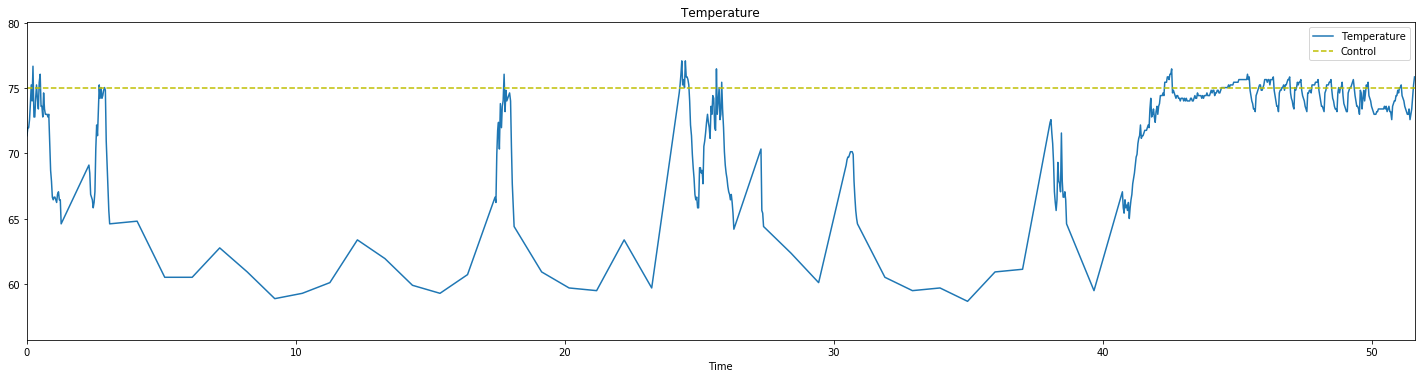

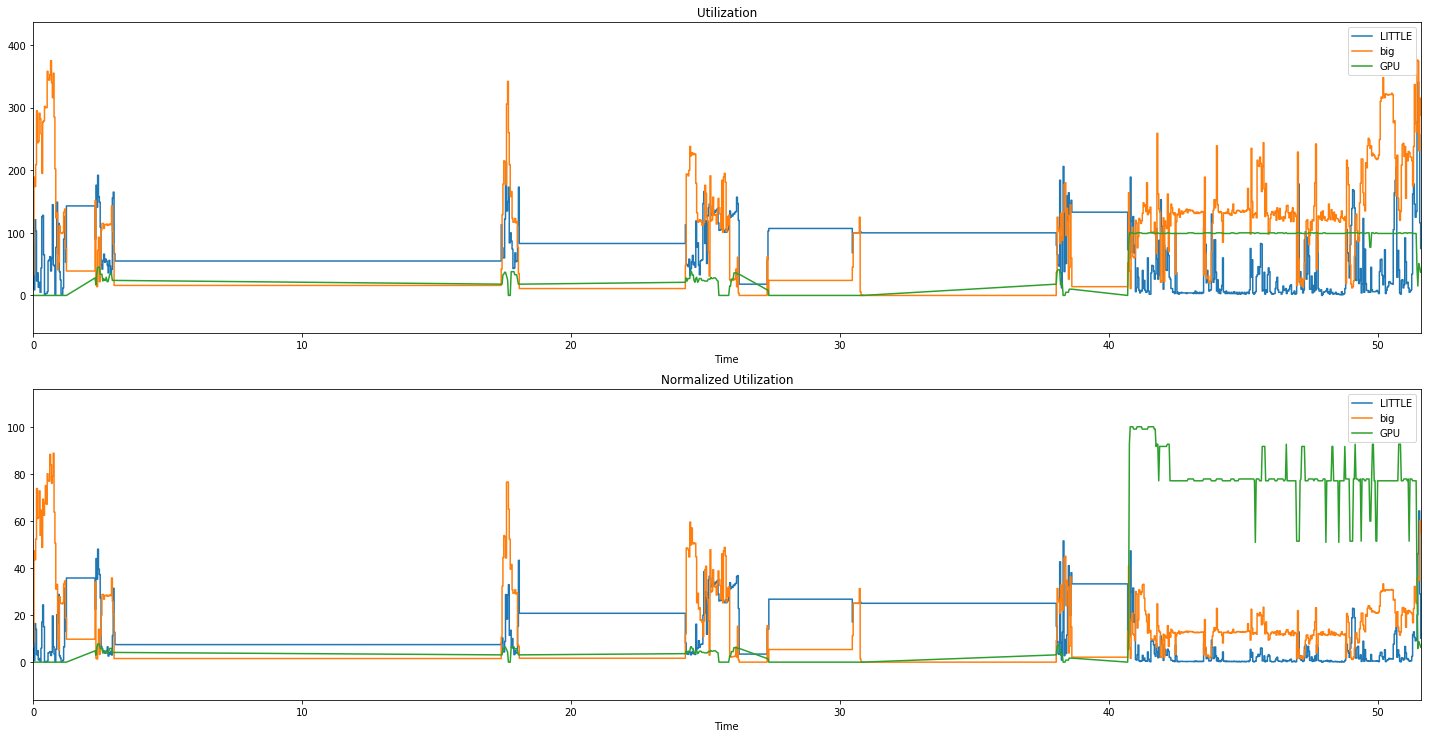

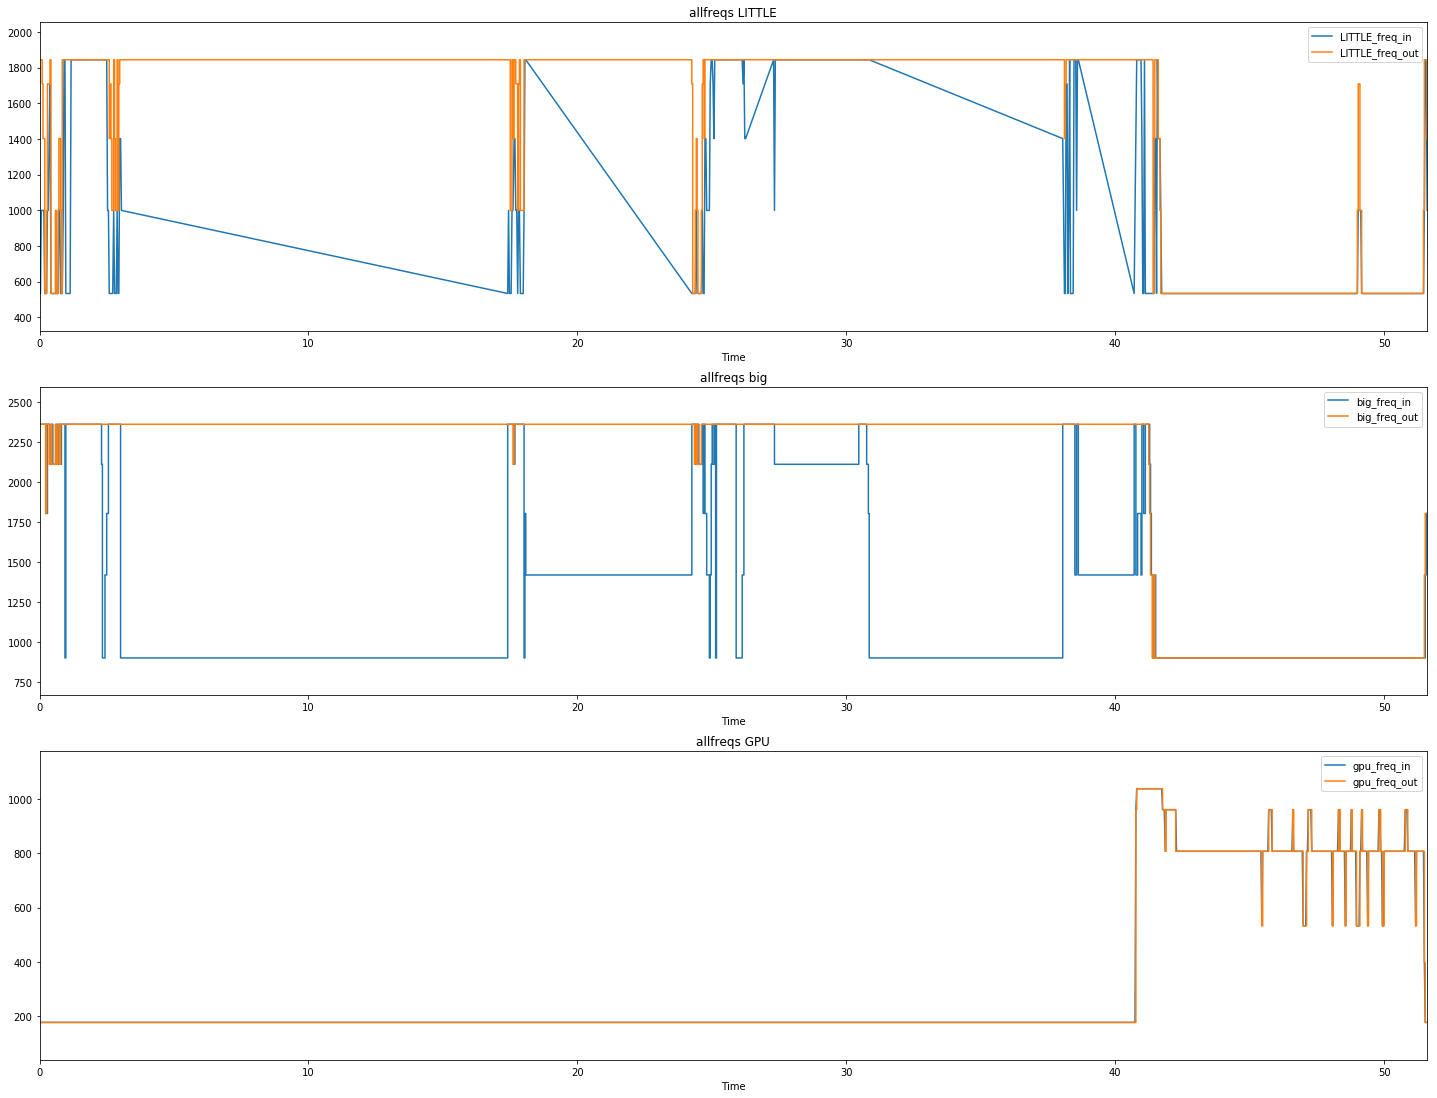

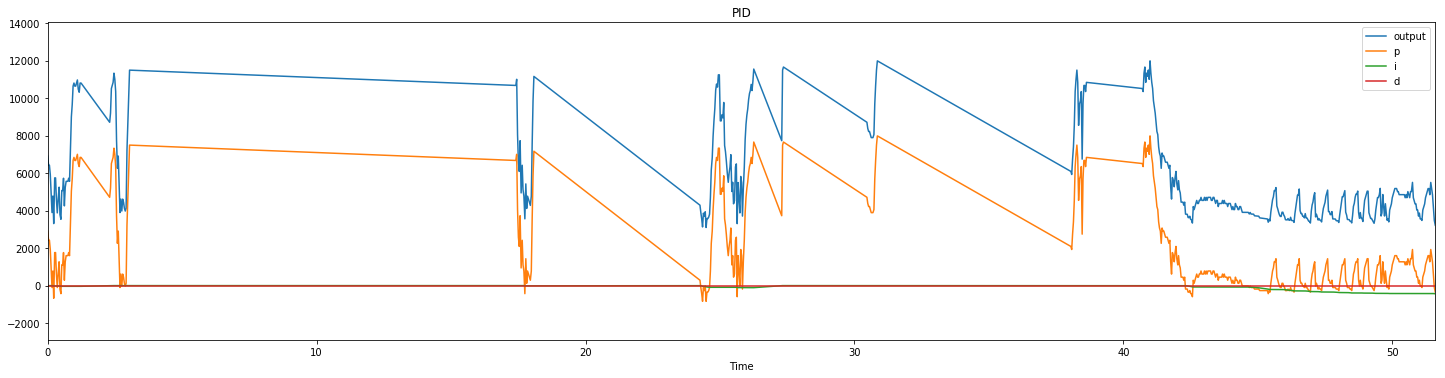

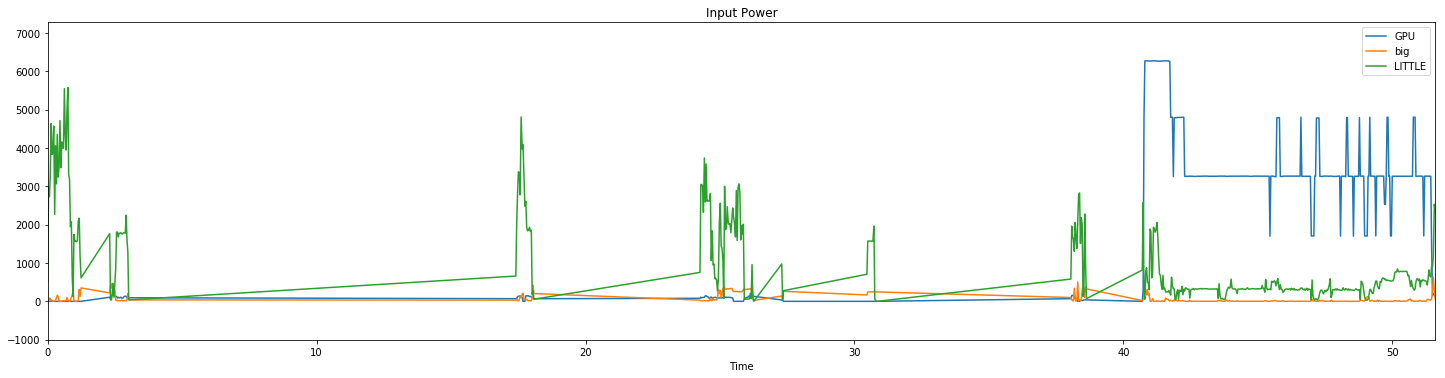

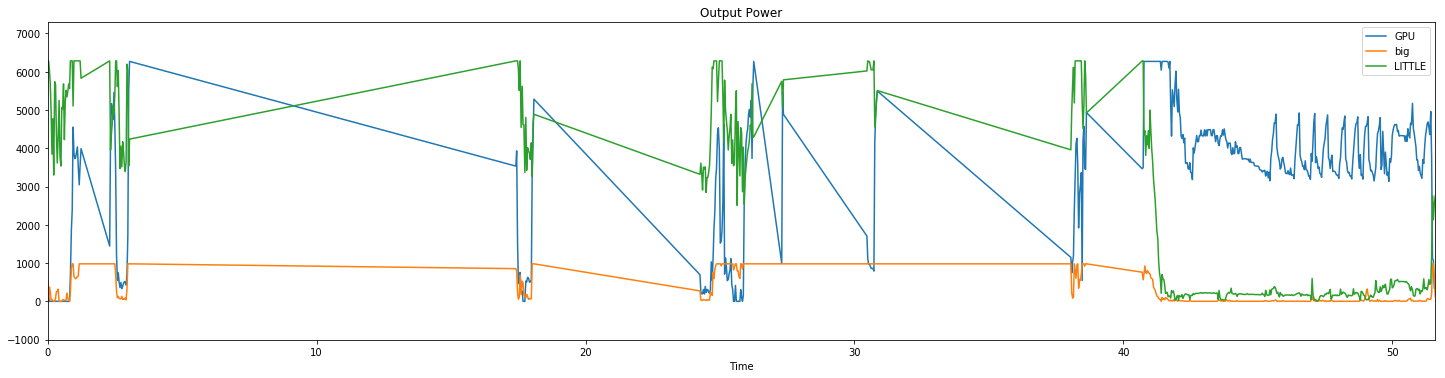

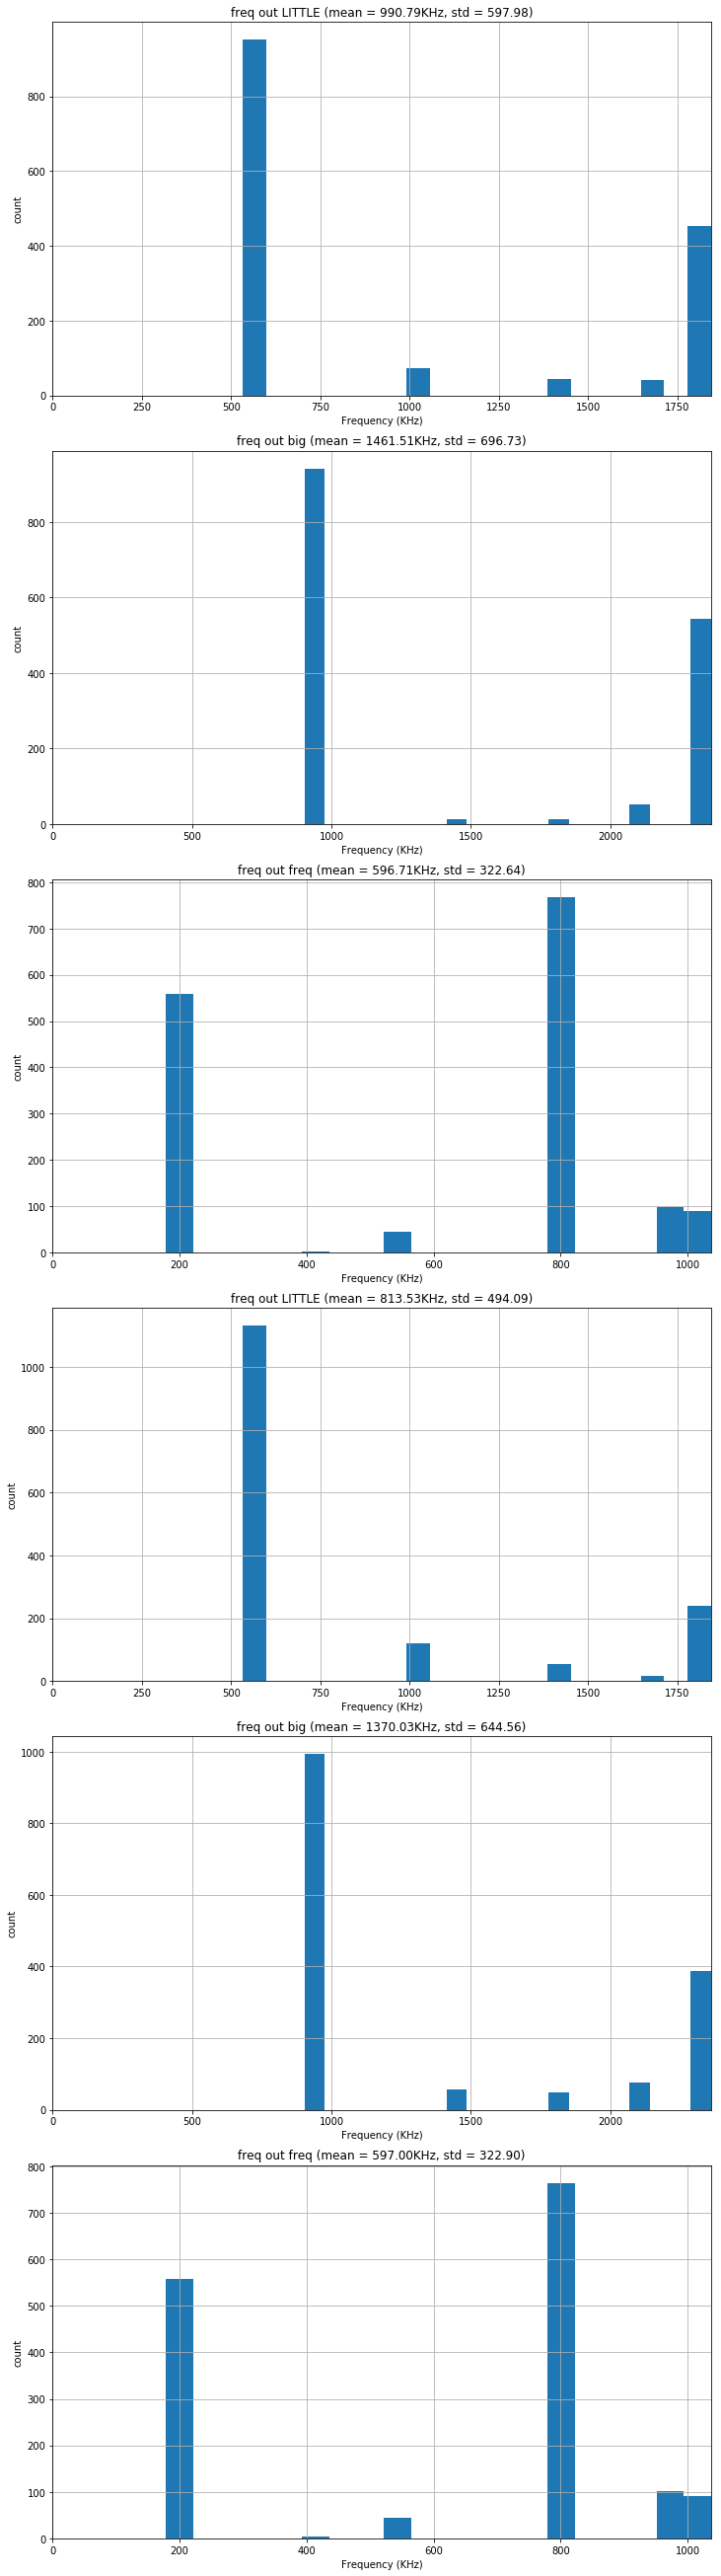

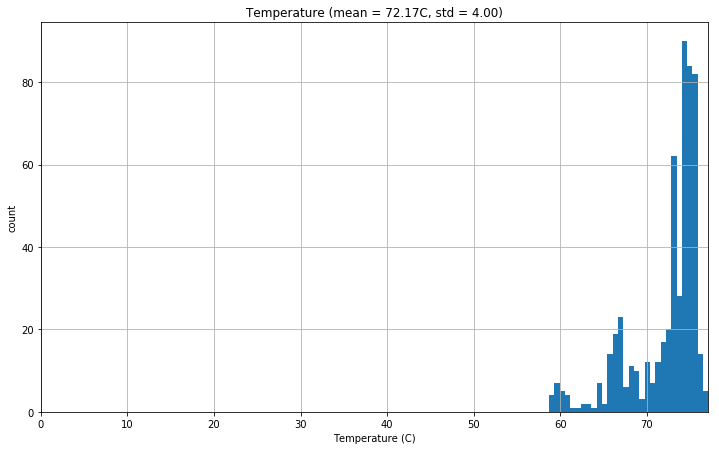

In [15]:
trappy.summary_plots(actor_order, map_label, path=os.path.join(te.res_dir, 'trace.dat'))